In [1]:
 from pyspark.sql import SparkSession
 spark = SparkSession.builder \
 .appName("Unsupervised Learning with MLlib") \
 .config("spark.executor.memory", "4g") \
 .getOrCreate()

In [3]:
from pyspark.ml.linalg import Vectors

data = [
    (Vectors.dense([5.1, 3.5, 1.4, 0.2]),),
    (Vectors.dense([4.9, 3.0, 1.4, 0.2]),),
    (Vectors.dense([4.7, 3.2, 1.3, 0.2]),),
    (Vectors.dense([7.0, 3.2, 4.7, 1.4]),),
    (Vectors.dense([6.4, 3.2, 4.5, 1.5]),),
    (Vectors.dense([6.9, 3.1, 4.9, 1.5]),)
]

df = spark.createDataFrame(data, ["features"])
df.show(truncate=False)

+-----------------+
|features         |
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[7.0,3.2,4.7,1.4]|
|[6.4,3.2,4.5,1.5]|
|[6.9,3.1,4.9,1.5]|
+-----------------+



In [5]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Fit scaler to the DataFrame and transform it
scaled_df = scaler.fit(df).transform(df)

# Show result
scaled_df.show(truncate=False)

+-----------------+-------------------------------------------------------------------------------+
|features         |scaled_features                                                                |
+-----------------+-------------------------------------------------------------------------------+
|[5.1,3.5,1.4,0.2]|[-0.698359914321749,1.7928429140015893,-0.892296547713937,-0.911609185753766]  |
|[4.9,3.0,1.4,0.2]|[-0.8888217091367706,-1.1952286093343947,-0.892296547713937,-0.911609185753766]|
|[4.7,3.2,1.3,0.2]|[-1.079283503951793,0.0,-0.946926948594382,-0.911609185753766]                 |
|[7.0,3.2,4.7,1.4]|[1.1110271364209625,0.0,0.9105066813407517,0.8156503240954749]                 |
|[6.4,3.2,4.5,1.5]|[0.5396417519758961,0.0,0.8012458795798614,0.9595886165829117]                 |
|[6.9,3.1,4.9,1.5]|[1.0157962390134516,-0.5976143046671973,1.0197674831016421,0.9595886165829117] |
+-----------------+-------------------------------------------------------------------------------+


In [6]:
from pyspark.ml.clustering import KMeans

# Buat model KMeans dengan 3 cluster
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=3, seed=1)

# Latih model KMeans pada data yang sudah diskalakan
model = kmeans.fit(scaled_df)

# Prediksi cluster untuk setiap data
predictions = model.transform(scaled_df)

# Tampilkan hasil
predictions.show(truncate=False)

+-----------------+-------------------------------------------------------------------------------+-------+
|features         |scaled_features                                                                |cluster|
+-----------------+-------------------------------------------------------------------------------+-------+
|[5.1,3.5,1.4,0.2]|[-0.698359914321749,1.7928429140015893,-0.892296547713937,-0.911609185753766]  |1      |
|[4.9,3.0,1.4,0.2]|[-0.8888217091367706,-1.1952286093343947,-0.892296547713937,-0.911609185753766]|2      |
|[4.7,3.2,1.3,0.2]|[-1.079283503951793,0.0,-0.946926948594382,-0.911609185753766]                 |2      |
|[7.0,3.2,4.7,1.4]|[1.1110271364209625,0.0,0.9105066813407517,0.8156503240954749]                 |0      |
|[6.4,3.2,4.5,1.5]|[0.5396417519758961,0.0,0.8012458795798614,0.9595886165829117]                 |0      |
|[6.9,3.1,4.9,1.5]|[1.0157962390134516,-0.5976143046671973,1.0197674831016421,0.9595886165829117] |0      |
+-----------------+---------

In [7]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluasi dengan Silhouette Score (semakin dekat ke 1, semakin baik)
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Within Set Sum of Squared Errors (WSSSE)
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

Silhouette with squared euclidean distance = 0.7117007722766514
Within Set Sum of Squared Errors = 1.1971234663070354


K=2, WSSSE=0.5133333333333331
K=3, WSSSE=0.2483333333333331
K=4, WSSSE=0.08000000000000007
K=5, WSSSE=0.03500000000000002
K=6, WSSSE=0.0


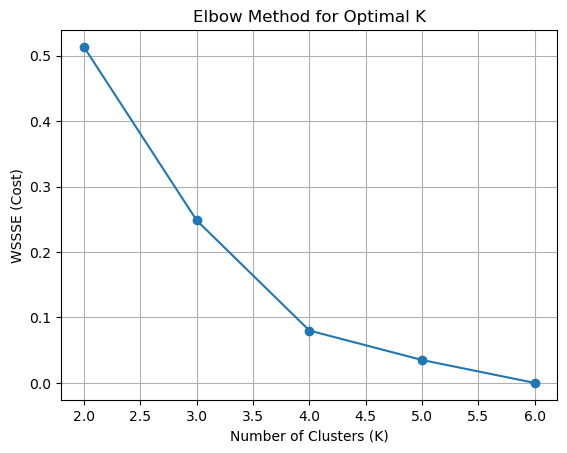

In [8]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

costs = []

for k in range(2, 7):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(scaled_df)
    cost = model.summary.trainingCost
    costs.append(cost)
    print(f"K={k}, WSSSE={cost}")

# Plotting Elbow Curve
plt.plot(range(2, 7), costs, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WSSSE (Cost)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [9]:
from pyspark.ml.feature import PCA

# Ganti 'features' ke 'scaled_features' sebagai input PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)

# Transform data
pca_result = pca_model.transform(scaled_df)

# Tampilkan hasil PCA
pca_result.select("pca_features").show(truncate=False)

+------------------------------------------+
|pca_features                              |
+------------------------------------------+
|[1.732365486800326,-1.5241518404130479]   |
|[1.3260426710595148,1.442234307893984]    |
|[1.6701386936600824,0.29866262298090673]  |
|[-1.6124962393413862,-0.29315991066877845]|
|[-1.3098807900030918,-0.21274962040009834]|
|[-1.8061698221754439,0.28916444060703694] |
+------------------------------------------+



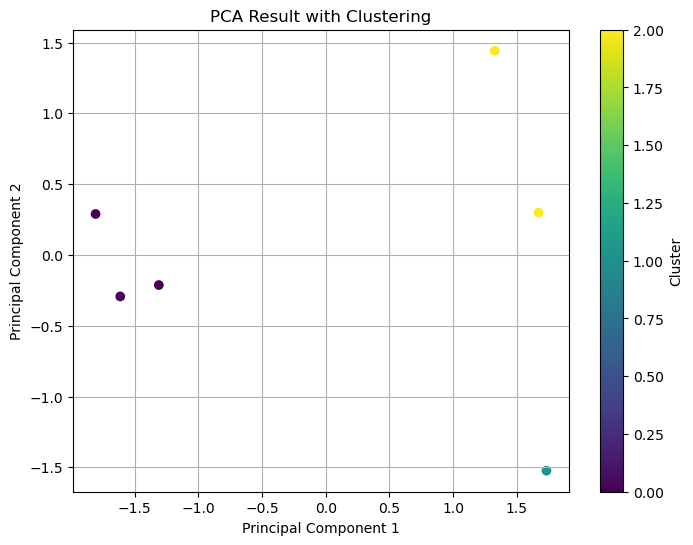

In [12]:
# Gabungkan hasil PCA dan hasil cluster (dalam kolom 'cluster')
pca_result_with_cluster = pca_result.join(predictions.select("features", "cluster"), on="features")

# Ambil kolom PCA dan cluster
pca_and_cluster = pca_result_with_cluster.select("pca_features", "cluster").collect()

# Ekstrak nilai-nilai untuk plotting
x = [float(row["pca_features"][0]) for row in pca_and_cluster]
y = [float(row["pca_features"][1]) for row in pca_and_cluster]
clusters = [row["cluster"] for row in pca_and_cluster]

# Visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result with Clustering')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

In [14]:
from pyspark.ml.clustering import KMeans

# Gunakan fitur dari PCA
kmeans_pca = KMeans().setK(3).setSeed(1).setFeaturesCol("pca_features")
pca_kmeans_model = kmeans_pca.fit(pca_result)

# Prediksi cluster
pca_predictions = pca_kmeans_model.transform(pca_result)

# Menampilkan hasil prediksi
pca_predictions.select("pca_features", "prediction").show(truncate=False)

+------------------------------------------+----------+
|pca_features                              |prediction|
+------------------------------------------+----------+
|[1.732365486800326,-1.5241518404130479]   |1         |
|[1.3260426710595148,1.442234307893984]    |2         |
|[1.6701386936600824,0.29866262298090673]  |2         |
|[-1.6124962393413862,-0.29315991066877845]|0         |
|[-1.3098807900030918,-0.21274962040009834]|0         |
|[-1.8061698221754439,0.28916444060703694] |0         |
+------------------------------------------+----------+



In [15]:
pca_data = pca_predictions.select("pca_features", "prediction").collect()
x = [row["pca_features"][0] for row in pca_data]
y = [row["pca_features"][1] for row in pca_data]
clusters = [row["prediction"] for row in pca_data]


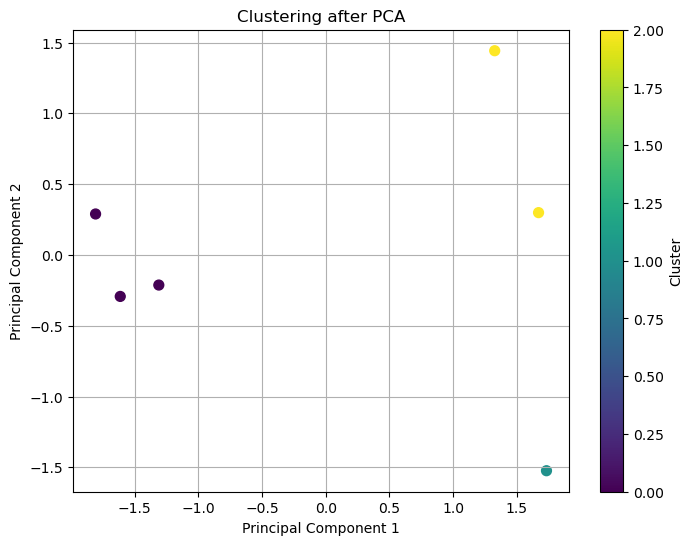

In [16]:
cluster_data = pca_predictions.select("pca_features", "prediction").collect()
x = [row["pca_features"][0] for row in cluster_data]
y = [row["pca_features"][1] for row in cluster_data]
clusters = [row["prediction"] for row in cluster_data]

plt.figure(figsize=(8,6))
plt.scatter(x, y, c=clusters, cmap='viridis', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering after PCA')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()